# Sur-Candes phase transition in logistic regression

Consider a logistic regression estimate $$
\hat\beta = \operatorname{argmin}_{b\in \mathbb R^p}
\sum_{i=1}^n \log(1+\exp(-y_i x_i^T b))
$$ where $y_i\in\{-1,1\}$ are binary responses and $x_i\in \mathbb R^p$
are feature vectors of dimension $p$. If a binary logistic model holds,
of the form $$x_i\sim N(0_p,I_p),
\qquad P(y_i=1|x_i)=\frac{1}{1+\exp(-y_ix_i^T\beta^*)}$$ for some ground
truth $\beta^*\in\mathbb R^p$ with $\|\beta^*\|=\gamma$, Candès and Sur
(2020) predicts the above optimization problem admits a solution if $$
\kappa < 
h(\gamma) = \min_{t\in \mathbb R} \mathbb E\Big[\max(0,t y_ix_i^T\beta^* + Z)^2\Big]
$$ where $n,p\to+\infty$ simultaneously with limiting ratio
$\kappa=\lim(p/n)$ and $Z\sim N(0,1)$ is independent of everything else;
while if $$
\kappa > h(\gamma)
$$ then no minimizer exists. The expectation on the right-hand side, as
well as its gradient with respect to $t\mathbb R$, can be computed by
numerical integration.

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy import stats
from scipy.integrate import simpson

## Solving the minimization using numerical integration

In [3]:
grid_integration_size = 60
gamma = 0.01 * (1.1 ** np.array(range(100))).reshape((-1, 1, 1, 1))
Z = np.linspace(-6,6, num=grid_integration_size).reshape((1, -1, 1, 1))
X = np.linspace(-6,6, num=grid_integration_size + 1).reshape((1, 1, -1, 1))
Y = np.array([1,-1]).reshape((1, 1, 1, 2))
conditional_pmf_Y = sigmoid(X*Y*gamma)


def E(x, keepdims=False):
    assert len(x.shape) == 4
    x = x * stats.norm.pdf(Z) * conditional_pmf_Y * stats.norm.pdf(X)
    x = np.sum(x, axis=3)
    x = simpson(x, x=X.squeeze(), axis=2)
    x = simpson(x, x=Z.squeeze(), axis=1)
    if keepdims:
        return x[..., np.newaxis, np.newaxis, np.newaxis]
    return x

Once we are able to integrate with respect to the joint distribution of
$(Z,X,Y)$, we simply perform a gradient descent to find the minimum over
$t$. The gradient of
$t\mapsto \mathbb E\big[\max(0,t y_ix_i^T\beta^* + Z)^2\big]$ is given
by $$
2 \mathbb E[ y_ix_i^T\beta^* \max(0,t y_ix_i^T\beta^* + Z) ].
$$ A simple gradient descent finds the scalar $t$ achieving the minimum
in the definition of $h(\gamma)$.

In [4]:
# initialization
t = 10 * np.ones_like(gamma)
# gradient descent
for _ in range(500):
    t += - 2 * E(Y * X * np.clip(t * Y * X - Z, a_min=0, a_max=None), keepdims=True)
    
kappa = E(np.clip(t * Y * X - Z, a_min=0, a_max=None)**2)

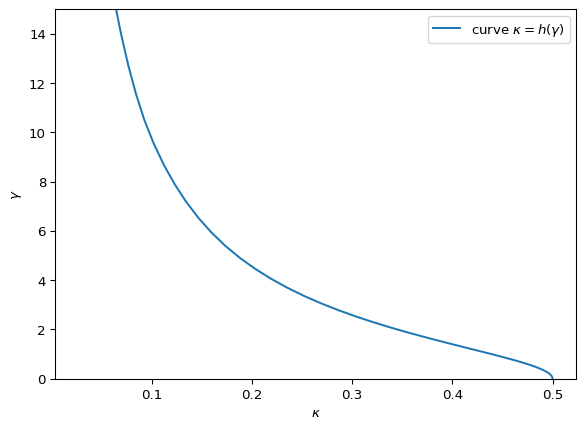

In [5]:
plt.plot(kappa.squeeze(), gamma.squeeze(), label=r"curve $\kappa=h(\gamma)$")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\gamma$")
plt.legend()
plt.ylim(0, 15)

## Simulation experiment

We now verify this phase transition empirically by verifying whether $$
\hat\beta = \operatorname{argmin}_{b\in \mathbb R^p}
\sum_{i=1}^n \log(1+\exp(-y_i x_i^T b))
$$ has a solution. The code below runs an iterative algorithm to solve
the above optimization problem. Either the algorithm converges, or the
the algorithm reaches the maximal number of iterations and returns a
direction $\hat b$ that perfectly separates the data, in the sense that
$\min_{i\in[n]} y_i \hat y_i  \ge 0$ where $\hat y_i = x_i\hat b$ for
each observation $i\in[n]$.

In [6]:
from sklearn.linear_model import LogisticRegression

def mle_exists(n, p, gamma, seed=2024):
    regr = LogisticRegression(penalty=None, fit_intercept=False)
    beta = gamma * np.ones(p)/np.sqrt(p)
    rng = np.random.default_rng(seed)
    X = rng.standard_normal(size=(n, p))
    y = - (-1) ** rng.binomial(1, sigmoid(X.dot(beta)))
    regr.fit(X, y)
    y_hat = X @ regr.coef_.reshape((p, ))
    return {'p': p, 'n': n, 'p':p, 'gamma': gamma, 'seed': seed, 'kappa': p/n,
            'MLE exists': not min(y * y_hat) >= 0.0}

mle_exists(1000, 200, 1.3)

{'p': 200,
 'n': 1000,
 'gamma': 1.3,
 'seed': 2024,
 'kappa': 0.2,
 'MLE exists': True}

We now experiment with $n=1000$, dimension $p$ ranging from 1 to
$n/2+50$, and $\gamma$ parameters equispaced from 0 to 12. For each
$(n,p,\gamma)$, the dataset is generated 10 times.

In [7]:
n = 1000
parameters = [{'n': 1000, 'p': p, 'gamma': g, 'seed': seed}
              for p in range(1, n//2 + 50, 5)
              for g in np.linspace(0, 12, num=100)
              for seed in range(10)]

In [8]:
from joblib import Parallel, delayed
f"Will now launch {len(parameters)} parallel tasks"

'Will now launch 110000 parallel tasks'

In [9]:
# Heavy parallel computation
data = Parallel(n_jobs=18, verbose=2)(delayed(mle_exists)(**d) for d in parameters)

## Visualizing the phase transition: theory versus empirical probabilities

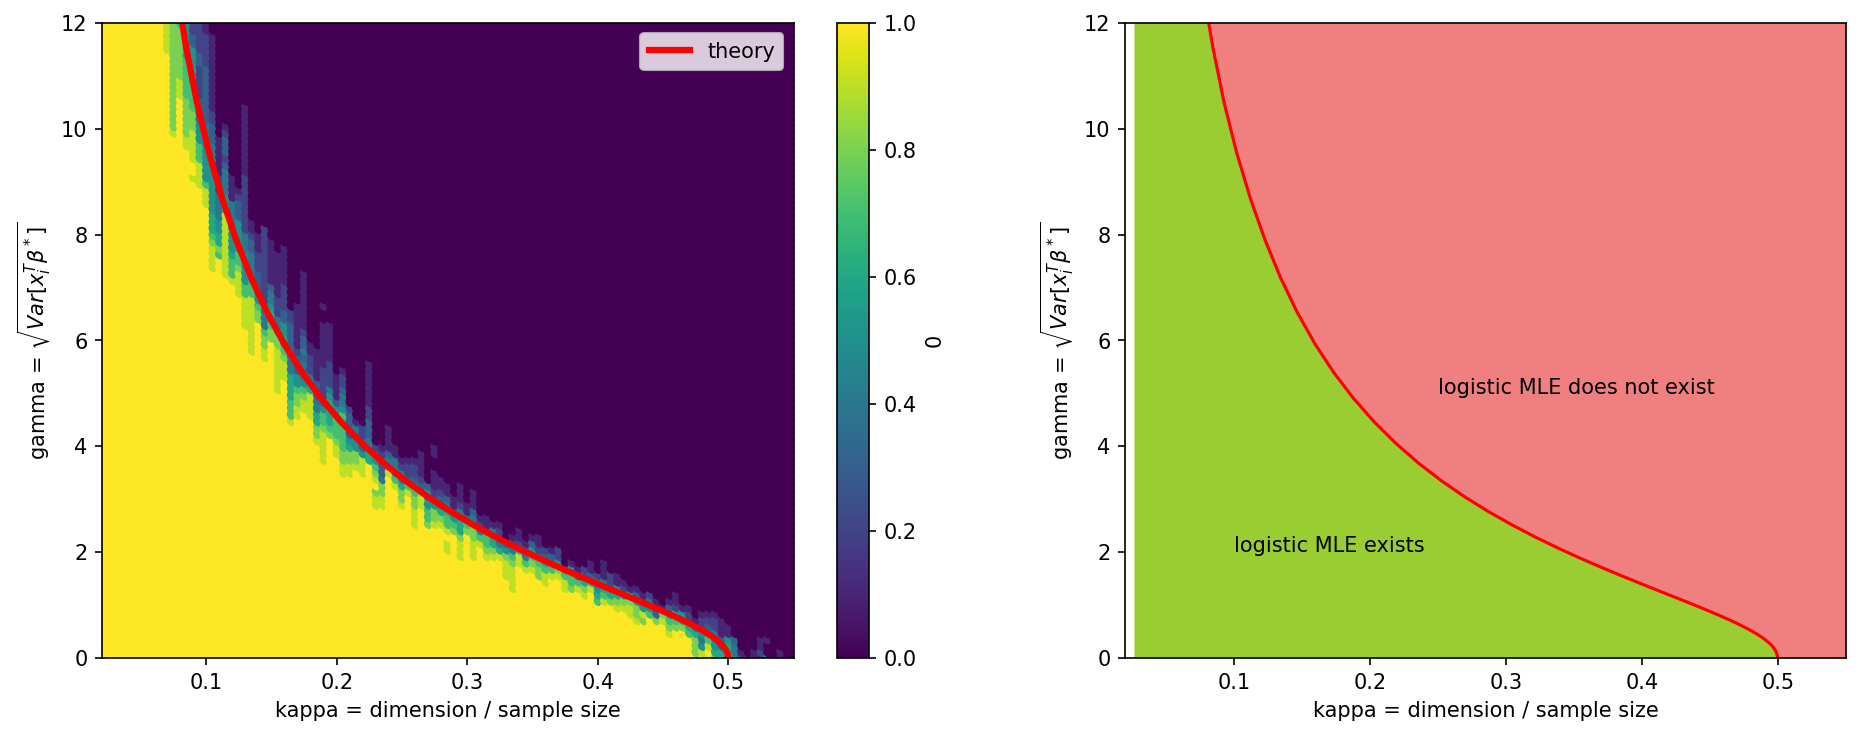

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
fig.set_size_inches(15, 5.5)

piv = pd.pivot_table(pd.DataFrame(data),
                     values='MLE exists',
                     index='gamma',
                     columns='kappa')
piv.unstack().reset_index().plot(x='kappa', y='gamma', c=0, kind='scatter', ax=ax1)
ax1.plot(kappa.squeeze(), gamma.squeeze(), color='red', label='theory', linewidth=3.0)
plt.xlabel('kappa = dimension / sample size')
plt.ylabel(r'gamma = $\sqrt{Var[x_i^T \beta^*]}$')
ax1.legend()

ax2.plot(kappa.squeeze(), gamma.squeeze(), color='red')
ax2.fill_between(kappa.squeeze(), gamma.squeeze(), color="yellowgreen")
maxy = ax2.get_ylim()[1]
ax2.fill_between(kappa.squeeze(), gamma.squeeze(), maxy, color="lightcoral")
ax2.fill_between(np.linspace(0.5, 0.6), np.zeros(50), maxy, color="lightcoral")


ax2.text(0.1, 2.0 ,"logistic MLE exists")
ax2.text(0.25, 5.0 ,"logistic MLE does not exist")

for ax in [ax1, ax2]:
    ax.set_ylabel(r'gamma = $\sqrt{Var[x_i^T \beta^*]}$')
    ax.set_xlabel('kappa = dimension / sample size')
    ax.set_xlim(0.02, 0.55)
    ax.set_ylim(0, 12)
    ax.margins(x=0, y=0)

Candès, Emmanuel J, and Pragya Sur. 2020. “The Phase Transition for the
Existence of the Maximum Likelihood Estimate in High-Dimensional
Logistic Regression.” *The Annals of Statistics* 48 (1): 27–42.